In [1]:
import os
import sys
sys.path.append('../src')
import numpy as np

from generator import generate_samples
from utils import split_and_preprocess
from adjustment_methods import (
    get_ate_ols,
    get_ate_cuped,
    get_ate_cupac,
    get_ate_doubly_robust,
)

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Using the generator to generate some samples

### With no covariates

In [2]:
data = generate_samples(
    mu_metric=5,
    sigma_metric=1,
    epsilon=2,
    treatment_effect=1,
    size=10_000,
    cov_mu_eps=[],
    non_linear=[],
    p_binomial=0.1,
    seed=0,
)
data

,Y,T,Y_before,R_1
0,11.380427,0,6.605055,-0.035140
1,4.032109,0,5.529775,0.599265
2,5.230410,0,5.131122,0.808710
3,7.496391,0,7.000880,0.470501
4,3.757591,0,5.150060,0.417555
...,...,...,...,...
9995,4.536001,0,6.248241,-0.557438
9996,4.528883,0,3.781479,0.854897
9997,6.560887,0,5.329774,0.306488
9998,3.388952,0,4.782307,2.669028


### With covariates

In [3]:
data = generate_samples(
    mu_metric=5,
    sigma_metric=1,
    epsilon=2,
    treatment_effect=2,
    size=10_000,
    cov_mu_eps=[(-1,1),(-2,1),(5,2)],
    non_linear=[False, False, True],
    p_binomial=0.5,
    seed=0,
)
data

,Y,T,Y_before,X_1,X_2,X_3,R_1
0,48.469499,1,7.964820,-2.061821,-1.756592,6.583826,-0.449224
1,1.154787,1,3.004992,-0.907129,-1.440026,0.612036,0.531393
2,12.488405,1,7.638295,1.451140,-2.097670,2.559668,0.625694
3,22.951901,1,6.567111,-1.397279,-2.789222,4.398647,-0.773556
4,65.078769,0,6.258385,-1.382051,-0.698056,7.950057,-0.792803
...,...,...,...,...,...,...,...
9995,44.148529,1,3.564813,-2.951965,-0.844310,6.410688,-0.615025
9996,8.770673,1,7.087529,-0.662689,-2.220826,-0.211942,-1.994352
9997,45.200630,0,3.367927,-0.524764,0.783742,6.507693,-1.108641
9998,29.565161,0,5.249341,-1.844544,-3.448299,5.333336,1.700324


# Getting a single ATE for this data

In [4]:
train_data, test_data = split_and_preprocess(data, treatment_effect=2)
len(train_data), len(test_data)

(5000, 5000)

# Mean Diff

In [5]:
test_data.loc[test_data['T']==1, 'Y'].mean() - test_data.loc[test_data['T']==0, 'Y'].mean()

1.550276523997777

### CUPED

Only uses outcome pre experiment

In [6]:
get_ate_cuped(test_data)

1.571561041408053

### Multivariable regression

In [7]:
get_ate_ols(test_data, covariates=["Y_before", "X_1", "X_2", "X_3"])

2.1296148785457265

### CUPAC

In [8]:
get_ate_cupac(test_data, train_data, covariates=["Y_before", "X_1", "X_2", "X_3"])

1.9704798257851017

### Doubly Robust

In [9]:
get_ate_doubly_robust(test_data, covariates=["Y_before", "X_1", "X_2", "X_3"])

1.940747315080742

## Simulating the experiment many times, supposing only linear effects

$$\epsilon \sim N(0,2)$$
$$Y_0 \sim N(20,10)$$
$$X_1 \sim N(-1,-1)$$
$$X_2 \sim N(-2,1)$$
$$X_3 \sim N(5,5)$$

$$Y = Y_0 + 0.1*T + X_1 + X_2 + X_3 + \epsilon$$

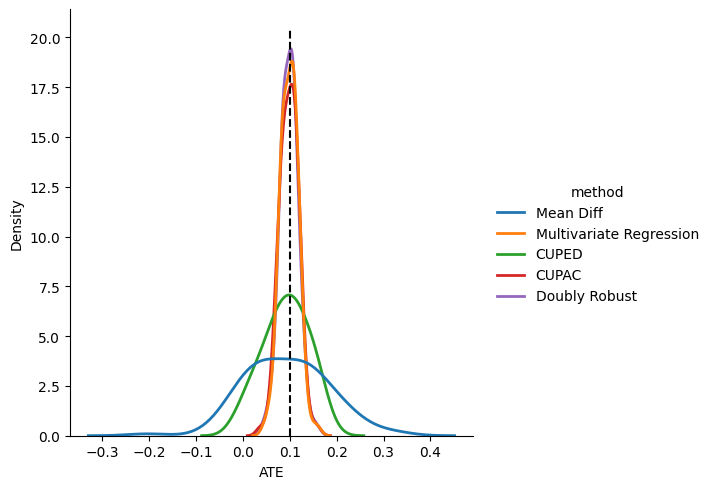

,method,mse
0,CUPAC,0.000387
1,CUPED,0.002392
2,Doubly Robust,0.000348
3,Mean Diff,0.007675
4,Multivariate Regression,0.000341


In [10]:
ate = []
ate_cuped = []
ate_ols_cov = []
ate_cupac = []
ate_doubly_robust = []

N_SAMPLES = 100_000
N_SIMULATIONS = 100
REAL_ATE = 0.1

for i in range(N_SIMULATIONS):
    data = generate_samples(
        mu_metric=20,
        sigma_metric=10,
        epsilon=2,
        treatment_effect=REAL_ATE,
        size=N_SAMPLES,
        cov_mu_eps=[(-1,1),(-2,1),(5,5)],
    )

    pre_analysis_data, analysis_data = split_and_preprocess(data, REAL_ATE)
    ate_cupac.append(get_ate_cupac(analysis_data, pre_analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))
    ate.append(analysis_data.loc[analysis_data['T']==1, 'Y'].mean() - analysis_data.loc[analysis_data['T']==0, 'Y'].mean())
    ate_ols_cov.append(get_ate_ols(analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))
    ate_cuped.append(get_ate_cuped(analysis_data))
    ate_doubly_robust.append(get_ate_doubly_robust(analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))

results = pd.DataFrame({
    'Mean Diff': ate,
    'Multivariate Regression': ate_ols_cov,
    'CUPED': ate_cuped,
    'CUPAC': ate_cupac,
    'Doubly Robust': ate_doubly_robust,
}).stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)
errors = pd.DataFrame({
    'Mean Diff': (np.array(ate) - REAL_ATE)**2,
    'Multivariate Regression': (np.array(ate_ols_cov) - REAL_ATE)**2,
    'CUPED': (np.array(ate_cuped) - REAL_ATE)**2,
    'CUPAC': (np.array(ate_cupac) - REAL_ATE)**2,
    'Doubly Robust': (np.array(ate_doubly_robust) - REAL_ATE)**2,
}).stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)


sns.displot(x='ATE',data=results, fill=False, kind='kde', hue='method', common_norm=False, linewidth=2, bw_adjust=1.2);
plt.vlines(REAL_ATE, plt.ylim()[0], plt.ylim()[1], linestyles="dashed", label='ATE',colors='k');
plt.show()
errors.groupby('method').agg(mse=('ATE', 'mean')).reset_index()

## Now simulating the same linear process, but using only a random variable as a covariate

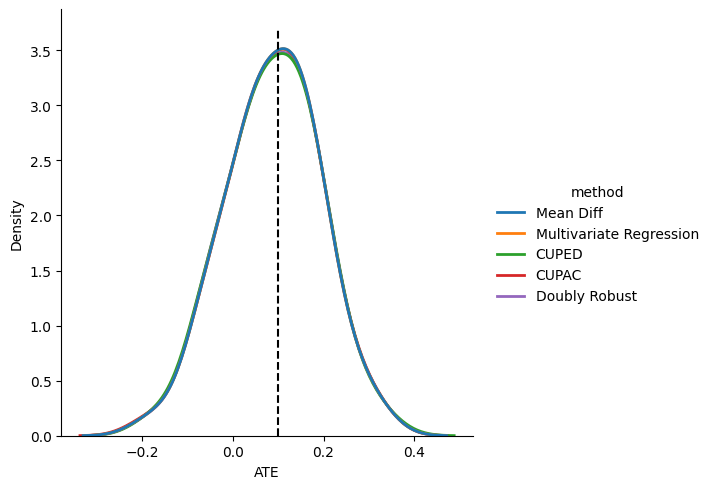

,method,mse
0,CUPAC,0.010336
1,CUPED,0.010392
2,Doubly Robust,0.010240
3,Mean Diff,0.010214
4,Multivariate Regression,0.010212


In [11]:
ate = []
ate_cuped = []
ate_ols_cov = []
ate_cupac = []
ate_doubly_robust = []

N_SAMPLES = 100_000
N_SIMULATIONS = 100
REAL_ATE = 0.1

for i in range(N_SIMULATIONS):
    data = generate_samples(
        mu_metric=20,
        sigma_metric=10,
        epsilon=2,
        treatment_effect=REAL_ATE,
        size=N_SAMPLES,
        cov_mu_eps=[(-1,1),(-2,1),(5,2)],
    )

    pre_analysis_data, analysis_data = split_and_preprocess(data, REAL_ATE)
    ate_cupac.append(get_ate_cupac(analysis_data, pre_analysis_data, covariates=['R_1']))
    ate.append(analysis_data.loc[analysis_data['T']==1, 'Y'].mean() - analysis_data.loc[analysis_data['T']==0, 'Y'].mean())
    ate_ols_cov.append(get_ate_ols(analysis_data, covariates=['R_1']))
    ate_cuped.append(get_ate_cuped(analysis_data, prediction_column='R_1'))
    ate_doubly_robust.append(get_ate_doubly_robust(analysis_data, covariates=['R_1']))

results = pd.DataFrame({
    'Mean Diff': ate,
    'Multivariate Regression': ate_ols_cov,
    'CUPED': ate_cuped,
    'CUPAC': ate_cupac,
    'Doubly Robust': ate_doubly_robust,
}).stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)
errors = pd.DataFrame({
    'Mean Diff': (np.array(ate) - REAL_ATE)**2,
    'Multivariate Regression': (np.array(ate_ols_cov) - REAL_ATE)**2,
    'CUPED': (np.array(ate_cuped) - REAL_ATE)**2,
    'CUPAC': (np.array(ate_cupac) - REAL_ATE)**2,
    'Doubly Robust': (np.array(ate_doubly_robust) - REAL_ATE)**2,
}).stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)


sns.displot(x='ATE',data=results, fill=False, kind='kde', hue='method', common_norm=False, linewidth=2, bw_adjust=1.2);
plt.vlines(REAL_ATE, plt.ylim()[0], plt.ylim()[1], linestyles="dashed", label='ATE',colors='k');
plt.show()
errors.groupby('method').agg(mse=('ATE', 'mean')).reset_index()

## Simulating now with non-linear effects

$$\epsilon \sim N(0,2)$$
$$Y_0 \sim N(20,10)$$
$$X_1 \sim N(-1,-1)$$
$$X_2 \sim N(-2,1)$$
$$X_3 \sim N(5,5)$$

$$Y = Y_0 + 0.1*T + X_1 + X_2 + X_3^2 + \epsilon$$

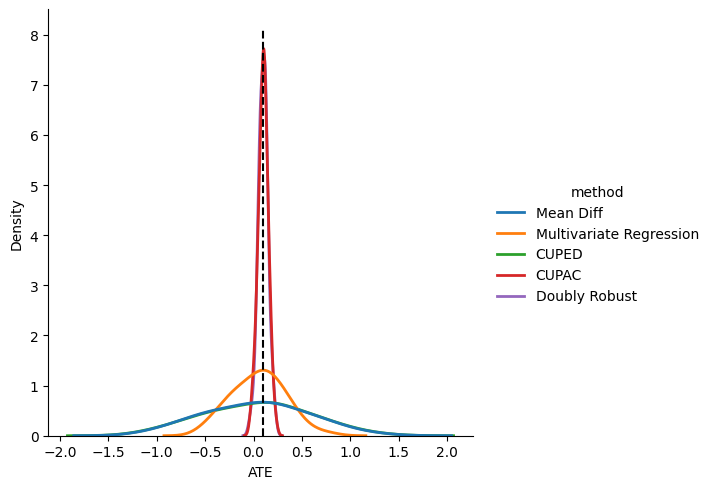

,method,mse
0,CUPAC,0.002434
1,CUPED,0.282346
2,Doubly Robust,0.002341
3,Mean Diff,0.275358
4,Multivariate Regression,0.075689


In [12]:
ate = []
ate_cuped = []
ate_ols_cov = []
ate_cupac = []
ate_doubly_robust = []

N_SAMPLES = 100_000
N_SIMULATIONS = 100
REAL_ATE = 0.1

for i in range(N_SIMULATIONS):
    data = generate_samples(
        mu_metric=20,
        sigma_metric=10,
        epsilon=2,
        treatment_effect=REAL_ATE,
        size=N_SAMPLES,
        cov_mu_eps=[(-1,1),(-2,1),(5,5)],
        non_linear=[False, False, True]
    )

    pre_analysis_data, analysis_data = split_and_preprocess(data, REAL_ATE)
    ate_cupac.append(get_ate_cupac(analysis_data, pre_analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))
    ate.append(analysis_data.loc[analysis_data['T']==1, 'Y'].mean() - analysis_data.loc[analysis_data['T']==0, 'Y'].mean())
    ate_ols_cov.append(get_ate_ols(analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))
    ate_cuped.append(get_ate_cuped(analysis_data))
    ate_doubly_robust.append(get_ate_doubly_robust(analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))

results = pd.DataFrame({
    'Mean Diff': ate,
    'Multivariate Regression': ate_ols_cov,
    'CUPED': ate_cuped,
    'CUPAC': ate_cupac,
    'Doubly Robust': ate_doubly_robust,
}).stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)
errors = pd.DataFrame({
    'Mean Diff': (np.array(ate) - REAL_ATE)**2,
    'Multivariate Regression': (np.array(ate_ols_cov) - REAL_ATE)**2,
    'CUPED': (np.array(ate_cuped) - REAL_ATE)**2,
    'CUPAC': (np.array(ate_cupac) - REAL_ATE)**2,
    'Doubly Robust': (np.array(ate_doubly_robust) - REAL_ATE)**2,
}).stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)


sns.displot(x='ATE',data=results, fill=False, kind='kde', hue='method', common_norm=False, linewidth=2, bw_adjust=1.2);
plt.vlines(REAL_ATE, plt.ylim()[0], plt.ylim()[1], linestyles="dashed", label='ATE',colors='k');
plt.show()
errors.groupby('method').agg(mse=('ATE', 'mean')).reset_index()